In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
bio   = pd.read_csv("data/processed/biometric_full.csv")
demo  = pd.read_csv("data/processed/demographic_full.csv")
enrol = pd.read_csv("data/processed/enrolment_full.csv")

bio.shape, demo.shape, enrol.shape


((1861108, 6), (2071700, 6), (1006029, 7))

In [3]:
def is_valid_district(d):
    if not isinstance(d, str):
        return False
    if d.isdigit():
        return False
    if len(d) < 3:
        return False
    return True

demo = demo[demo["district"].apply(is_valid_district)]
enrol = enrol[enrol["district"].apply(is_valid_district)]

print("Demo districts:", demo["district"].nunique())
print("Enrol districts:", enrol["district"].nunique())


Demo districts: 982
Enrol districts: 984


In [4]:
common_districts = set(demo["district"]) & set(enrol["district"])

demo = demo[demo["district"].isin(common_districts)]
enrol = enrol[enrol["district"].isin(common_districts)]

print("Common districts used:", len(common_districts))

Common districts used: 949


In [ ]:
demo["district"] = demo["district"].str.upper().str.strip()
enrol["district"] = enrol["district"].str.upper().str.strip()

demo["date"] = pd.to_datetime(demo["date"], dayfirst=True)


In [5]:
demo["total_demo_updates"] = (
    demo["demo_age_5_17"] + demo["demo_age_17_"]
)


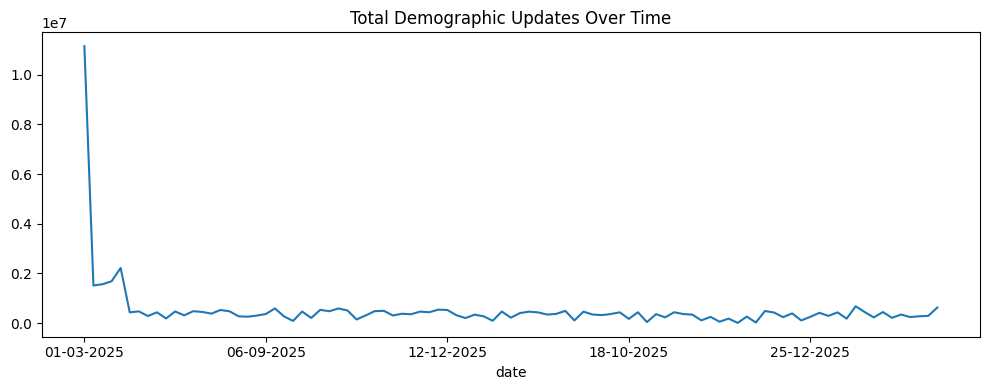

In [6]:
trend_time = demo.groupby("date")["total_demo_updates"].sum()

trend_time.plot(figsize=(10,4), title="Total Demographic Updates Over Time")
plt.tight_layout()
plt.savefig("outputs/demographic_updates_over_time.png")
plt.show()


In [7]:
district_demo = (
    demo
    .groupby("district", as_index=False)
    .agg({
        "demo_age_5_17": "sum",
        "demo_age_17_": "sum"
    })
)

district_demo["total_demo_updates"] = (
    district_demo["demo_age_5_17"] + district_demo["demo_age_17_"]
)

district_demo.head()


,district,demo_age_5_17,demo_age_17_,total_demo_updates
0,ANGUL,1,8,9
1,ANUGUL,4,141,145
2,Adilabad,9009,66292,75301
3,Agar Malwa,965,8919,9884
4,Agra,18477,157476,175953


In [8]:
district_demo.to_csv(
    "outputs/district_demographic_pressure.csv",
    index=False
)


In [9]:
district_enrol = (
    enrol.groupby("district", as_index=False)
         .agg({
             "age_0_5": "sum",
             "age_5_17": "sum",
             "age_18_greater": "sum"
         })
)

district_enrol.head()


,district,age_0_5,age_5_17,age_18_greater
0,ANGUL,1,0,0
1,ANUGUL,12,1,0
2,Adilabad,3654,748,4
3,Agar Malwa,2087,421,29
4,Agra,16314,12691,905


In [10]:
district_enrol = (
    enrol
    .groupby("district", as_index=False)
    .agg({
        "age_0_5": "sum",
        "age_5_17": "sum",
        "age_18_greater": "sum"
    })
)

district_enrol.head()


,district,age_0_5,age_5_17,age_18_greater
0,ANGUL,1,0,0
1,ANUGUL,12,1,0
2,Adilabad,3654,748,4
3,Agar Malwa,2087,421,29
4,Agra,16314,12691,905


In [11]:
district_merged = district_demo.merge(
    district_enrol,
    on="district",
    how="inner"
)

district_merged.head()


,district,demo_age_5_17,demo_age_17_,total_demo_updates,age_0_5,age_5_17,age_18_greater
0,ANGUL,1,8,9,1,0,0
1,ANUGUL,4,141,145,12,1,0
2,Adilabad,9009,66292,75301,3654,748,4
3,Agar Malwa,965,8919,9884,2087,421,29
4,Agra,18477,157476,175953,16314,12691,905


In [12]:
district_merged["demo_update_rate"] = (
    district_merged["total_demo_updates"] /
    (
        district_merged["age_0_5"] +
        district_merged["age_5_17"] +
        district_merged["age_18_greater"]
    )
)

district_merged[["district", "demo_update_rate"]].head()


,district,demo_update_rate
0,ANGUL,9.000000
1,ANUGUL,11.153846
2,Adilabad,17.090558
3,Agar Malwa,3.895940
4,Agra,5.882748


In [13]:
district_merged.to_csv(
    "outputs/district_demographic_update_rate.csv",
    index=False
)
